In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim

In [2]:
torch.manual_seed(42)
BATCH_SIZE= 32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset= MNIST(root= './data', train= True, download= True, transform= transform)
test_dataset= MNIST(root= './data', train= False, download= True, transform= transform)
train_loader= DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True)
test_loader= DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle= False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.64MB/s]


In [3]:
len(train_dataset), len(test_dataset)

(60000, 10000)

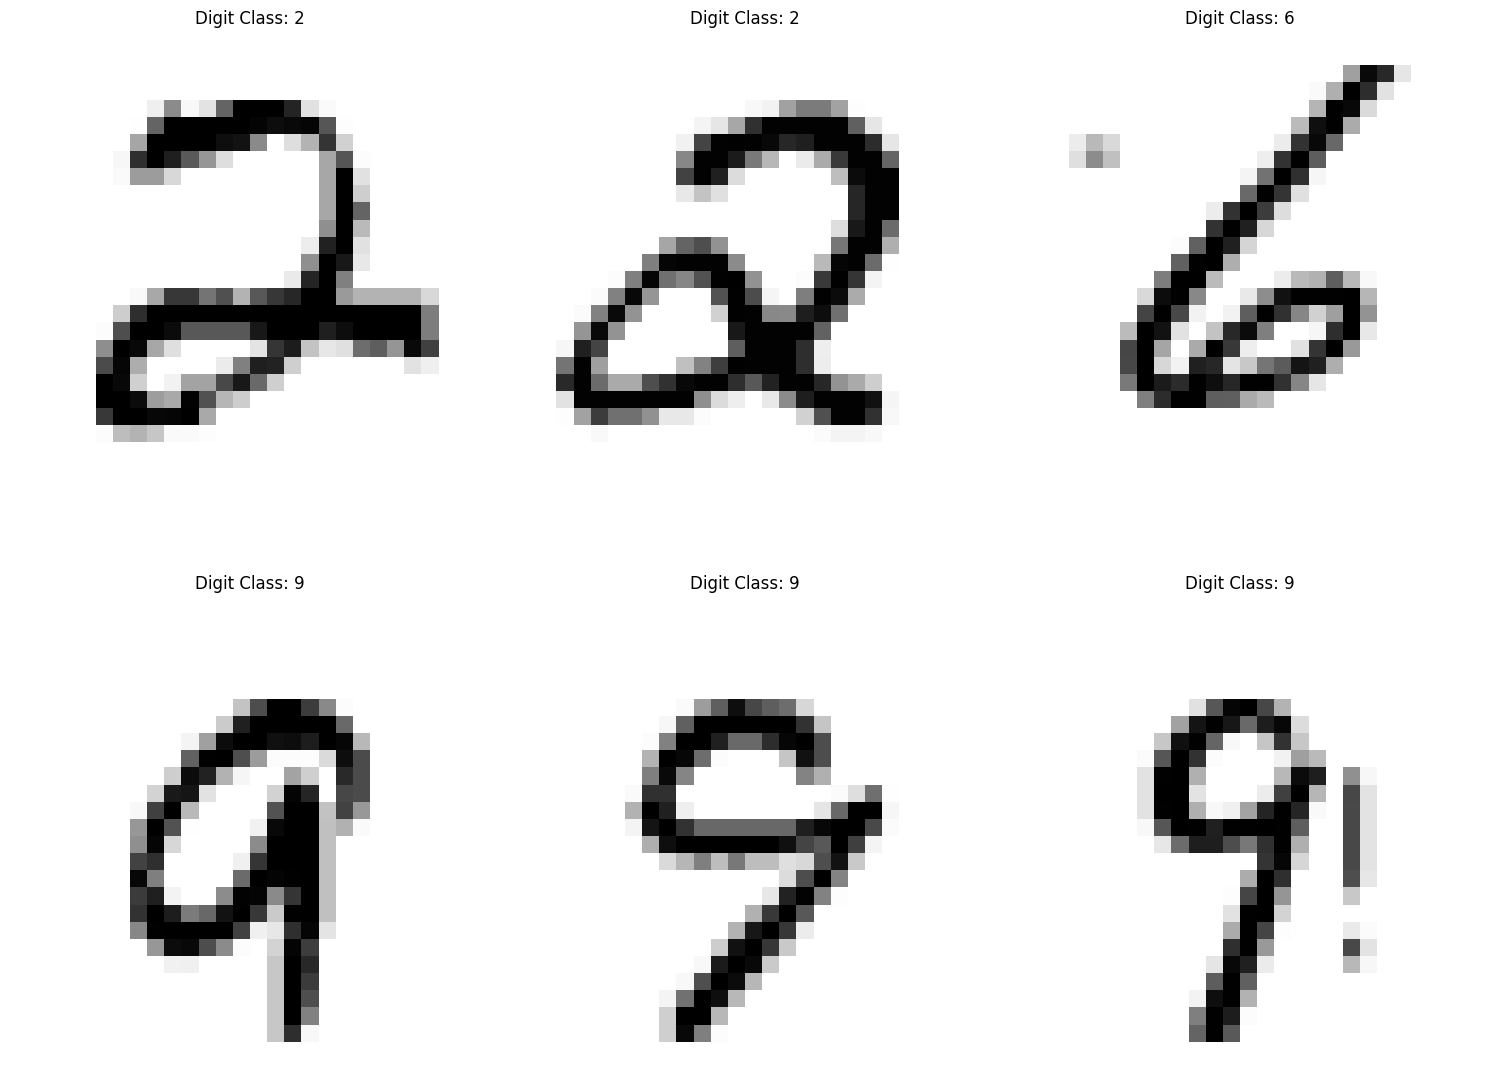

In [4]:
def display_images(images, labels, indices, n_rows= 2, n_cols= 3, figsize= (15,12)):
    fig, axes= plt.subplots(n_rows, n_cols, figsize= figsize)

    axes= axes.flatten()
    for i, idx in enumerate(indices):
        image= images[idx].numpy()
        label= labels[idx].item()

        axes[i].imshow(image.squeeze(), cmap= plt.cm.binary)
        axes[i].axis(False)
        axes[i].set_title(f"Digit Class: {label}")
    plt.tight_layout()
    plt.show()

images, labels= next(iter(train_loader))
indices= [1, 4, 5, 6, 7, 8]
display_images(images, labels, indices)

In [5]:
class DefaultMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 512) # Input Shape: 28x28= 784, Out Shape: 256
        self.relu1= nn.ReLU()

        self.fc2= nn.Linear(512, 256) # Input Shape: 256, Out Shape: 128
        self.relu2= nn.ReLU()


        self.output= nn.Linear(256, 10) # In Shape: 128, Outshape: num classes = 10

        self.activation_std_history= [] # List of Dicts: [{'fc1': std, ....}, ...]
        self.gradient_std_history= [] # Same for gradients



    def forward(self, x):

        x= x.view(x.size(0), -1)
        features= self.relu1(self.fc1(x))
        features= self.relu2(self.fc2(features))
        out_logits= self.output(features)

        return out_logits

    def register_std_hooks(self):
        # Temporary trackers for current pass
        self.activation_stds = {}
        self.gradient_stds = {}
        # Forward hook function (closure)
        def forward_hook(module, input, output):
              # Compute std of output activations (flatten to 1D for global std)
              layer_name= module.__class__.__name__
              if output.numel() > 1:  # Avoid std on empty/scalar tensors
                  std = torch.std(output.detach().view(-1)).item()
                  self.activation_stds[layer_name] = std
              else:
                  self.activation_stds[layer_name] = 0.0  # Fallback


        # Backward hook function (closure)
        def backward_hook(module, grad_input, grad_output):
              layer_name= module.__class__.__name__
              if grad_output[0] is not None and grad_output[0].numel() > 1:
                  std = torch.std(grad_output[0].detach().view(-1)).item()
                  self.gradient_stds[layer_name] = std
              else:
                  self.gradient_stds[layer_name] = 0.0  # Fallback



        # Register hooks on key layers
        self.fc1.register_forward_hook(forward_hook)
        self.fc1.register_full_backward_hook(backward_hook)

        self.fc2.register_forward_hook(forward_hook)
        self.fc2.register_full_backward_hook(backward_hook)

        self.relu1.register_forward_hook(forward_hook)
        self.relu1.register_full_backward_hook(backward_hook)

        self.relu2.register_forward_hook(forward_hook)
        self.relu2.register_full_backward_hook(backward_hook)

        self.output.register_forward_hook(forward_hook)
        self.output.register_full_backward_hook(backward_hook)

    # Append current pass stds to history and clear temp trackers (unchanged, it's good)
    def log_std_to_history(self):
        self.activation_std_history.append(self.activation_stds.copy())
        self.gradient_std_history.append(self.gradient_stds.copy())
        self.activation_stds = {}
        self.gradient_stds = {}

In [6]:
class XavierUniformMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 512) # Input Shape: 28x28= 784, Out Shape: 256
        self.relu1= nn.ReLU()
        nn.init.xavier_uniform_(self.fc1.weight, gain= nn.init.calculate_gain('relu'))

        self.fc2= nn.Linear(512, 256) # Input Shape: 256, Out Shape: 128
        self.relu2= nn.ReLU()
        nn.init.xavier_uniform_(self.fc2.weight, gain= nn.init.calculate_gain('relu'))


        self.output= nn.Linear(256, 10) # In Shape: 128, Outshape: num classes = 10

        if self.fc1.bias is not None:
            nn.init.constant_(self.fc1.bias, 0)
        if self.fc2.bias is not None:
            nn.init.constant_(self.fc2.bias, 0)

        self.activation_std_history= [] # List of Dicts: [{'fc1': std, ....}, ...]
        self.gradient_std_history= [] # Same for gradients

    def forward(self, x):

        x= x.view(x.size(0), -1)
        features= self.relu1(self.fc1(x))
        features= self.relu2(self.fc2(features))
        out_logits= self.output(features)

        return out_logits

    def register_std_hooks(self):
        # Temporary trackers for current pass
        self.activation_stds = {}
        self.gradient_stds = {}
        # Forward hook function (closure)
        def forward_hook(module, input, output):
              # Compute std of output activations (flatten to 1D for global std)
              layer_name= module.__class__.__name__
              if output.numel() > 1:  # Avoid std on empty/scalar tensors
                  std = torch.std(output.detach().view(-1)).item()
                  self.activation_stds[layer_name] = std
              else:
                  self.activation_stds[layer_name] = 0.0  # Fallback


        # Backward hook function (closure)
        def backward_hook(module, grad_input, grad_output):
              layer_name= module.__class__.__name__
              if grad_output[0] is not None and grad_output[0].numel() > 1:
                  std = torch.std(grad_output[0].detach().view(-1)).item()
                  self.gradient_stds[layer_name] = std
              else:
                  self.gradient_stds[layer_name] = 0.0  # Fallback



        # Register hooks on key layers
        self.fc1.register_forward_hook(forward_hook)
        self.fc1.register_full_backward_hook(backward_hook)

        self.fc2.register_forward_hook(forward_hook)
        self.fc2.register_full_backward_hook(backward_hook)

        self.relu1.register_forward_hook(forward_hook)
        self.relu1.register_full_backward_hook(backward_hook)

        self.relu2.register_forward_hook(forward_hook)
        self.relu2.register_full_backward_hook(backward_hook)

        self.output.register_forward_hook(forward_hook)
        self.output.register_full_backward_hook(backward_hook)

    # Append current pass stds to history and clear temp trackers (unchanged, it's good)
    def log_std_to_history(self):
        self.activation_std_history.append(self.activation_stds.copy())
        self.gradient_std_history.append(self.gradient_stds.copy())
        self.activation_stds = {}
        self.gradient_stds = {}

In [7]:
class XavierNormalMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 512) # Input Shape: 28x28= 784, Out Shape: 256
        nn.init.xavier_normal_(self.fc1.weight, gain= nn.init.calculate_gain('relu'))
        self.relu1= nn.ReLU()

        self.fc2= nn.Linear(512, 256) # Input Shape: 256, Out Shape: 128
        self.relu2= nn.ReLU()
        nn.init.xavier_normal_(self.fc2.weight, gain= nn.init.calculate_gain('relu'))


        self.output= nn.Linear(256, 10) # In Shape: 128, Outshape: num classes = 10

        if self.fc1.bias is not None:
            nn.init.constant_(self.fc1.bias, 0)
        if self.fc2.bias is not None:
            nn.init.constant_(self.fc2.bias, 0)

        self.activation_std_history= [] # List of Dicts: [{'fc1': std, ....}, ...]
        self.gradient_std_history= [] # Same for gradients

    def forward(self, x):

        x= x.view(x.size(0), -1)
        features= self.relu1(self.fc1(x))
        features= self.relu2(self.fc2(features))
        out_logits= self.output(features)

        return out_logits

    def register_std_hooks(self):
        # Temporary trackers for current pass
        self.activation_stds = {}
        self.gradient_stds = {}
        # Forward hook function (closure)
        def forward_hook(module, input, output):
              # Compute std of output activations (flatten to 1D for global std)
              layer_name= module.__class__.__name__
              if output.numel() > 1:  # Avoid std on empty/scalar tensors
                  std = torch.std(output.detach().view(-1)).item()
                  self.activation_stds[layer_name] = std
              else:
                  self.activation_stds[layer_name] = 0.0  # Fallback


        # Backward hook function (closure)
        def backward_hook(module, grad_input, grad_output):
              layer_name= module.__class__.__name__
              if grad_output[0] is not None and grad_output[0].numel() > 1:
                  std = torch.std(grad_output[0].detach().view(-1)).item()
                  self.gradient_stds[layer_name] = std
              else:
                  self.gradient_stds[layer_name] = 0.0  # Fallback



        # Register hooks on key layers
        self.fc1.register_forward_hook(forward_hook)
        self.fc1.register_full_backward_hook(backward_hook)

        self.fc2.register_forward_hook(forward_hook)
        self.fc2.register_full_backward_hook(backward_hook)

        self.relu1.register_forward_hook(forward_hook)
        self.relu1.register_full_backward_hook(backward_hook)

        self.relu2.register_forward_hook(forward_hook)
        self.relu2.register_full_backward_hook(backward_hook)

        self.output.register_forward_hook(forward_hook)
        self.output.register_full_backward_hook(backward_hook)

    # Append current pass stds to history and clear temp trackers (unchanged, it's good)
    def log_std_to_history(self):
        self.activation_std_history.append(self.activation_stds.copy())
        self.gradient_std_history.append(self.gradient_stds.copy())
        self.activation_stds = {}
        self.gradient_stds = {}

In [8]:
class KaimingUniformMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 512) # Input Shape: 28x28= 784, Out Shape: 256
        nn.init.kaiming_uniform_(self.fc1.weight, mode= 'fan_in', nonlinearity= 'relu')
        self.relu1= nn.ReLU()

        self.fc2= nn.Linear(512, 256) # Input Shape: 256, Out Shape: 128
        nn.init.kaiming_uniform_(self.fc2.weight, mode= 'fan_in', nonlinearity= 'relu')
        self.relu2= nn.ReLU()

        self.output= nn.Linear(256, 10) # In Shape: 128, Outshape: num classes = 10
        if self.fc1.bias is not None:
            nn.init.constant_(self.fc1.bias, 0)
        if self.fc2.bias is not None:
            nn.init.constant_(self.fc2.bias, 0)

        self.activation_std_history= [] # List of Dicts: [{'fc1': std, ....}, ...]
        self.gradient_std_history= [] # Same for gradients

    def forward(self, x):

        x= x.view(x.size(0), -1)
        features= self.relu1(self.fc1(x))
        features= self.relu2(self.fc2(features))
        out_logits= self.output(features)

        return out_logits

    def register_std_hooks(self):
        # Temporary trackers for current pass
        self.activation_stds = {}
        self.gradient_stds = {}
        # Forward hook function (closure)
        def forward_hook(module, input, output):
              # Compute std of output activations (flatten to 1D for global std)
              layer_name= module.__class__.__name__
              if output.numel() > 1:  # Avoid std on empty/scalar tensors
                  std = torch.std(output.detach().view(-1)).item()
                  self.activation_stds[layer_name] = std
              else:
                  self.activation_stds[layer_name] = 0.0  # Fallback


        # Backward hook function (closure)
        def backward_hook(module, grad_input, grad_output):
              layer_name= module.__class__.__name__
              if grad_output[0] is not None and grad_output[0].numel() > 1:
                  std = torch.std(grad_output[0].detach().view(-1)).item()
                  self.gradient_stds[layer_name] = std
              else:
                  self.gradient_stds[layer_name] = 0.0  # Fallback



        # Register hooks on key layers
        self.fc1.register_forward_hook(forward_hook)
        self.fc1.register_full_backward_hook(backward_hook)

        self.fc2.register_forward_hook(forward_hook)
        self.fc2.register_full_backward_hook(backward_hook)

        self.relu1.register_forward_hook(forward_hook)
        self.relu1.register_full_backward_hook(backward_hook)

        self.relu2.register_forward_hook(forward_hook)
        self.relu2.register_full_backward_hook(backward_hook)

        self.output.register_forward_hook(forward_hook)
        self.output.register_full_backward_hook(backward_hook)

    # Append current pass stds to history and clear temp trackers (unchanged, it's good)
    def log_std_to_history(self):
        self.activation_std_history.append(self.activation_stds.copy())
        self.gradient_std_history.append(self.gradient_stds.copy())
        self.activation_stds = {}
        self.gradient_stds = {}

In [9]:
class KaimingNormalMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 512) # Input Shape: 28x28= 784, Out Shape: 256
        nn.init.kaiming_normal_(self.fc1.weight, mode= 'fan_in', nonlinearity= 'relu')
        self.relu1= nn.ReLU()

        self.fc2= nn.Linear(512, 256) # Input Shape: 256, Out Shape: 128
        nn.init.kaiming_normal_(self.fc2.weight, mode= 'fan_in', nonlinearity= 'relu')
        self.relu2= nn.ReLU()

        self.output= nn.Linear(256, 10) # In Shape: 128, Outshape: num classes = 10

        if self.fc1.bias is not None:
            nn.init.constant_(self.fc1.bias, 0)
        if self.fc2.bias is not None:
            nn.init.constant_(self.fc2.bias, 0)

        self.activation_std_history= [] # List of Dicts: [{'fc1': std, ....}, ...]
        self.gradient_std_history= [] # Same for gradients

    def forward(self, x):

        x= x.view(x.size(0), -1)
        features= self.relu1(self.fc1(x))
        features= self.relu2(self.fc2(features))
        out_logits= self.output(features)

        return out_logits

    def register_std_hooks(self):
        # Temporary trackers for current pass
        self.activation_stds = {}
        self.gradient_stds = {}
        # Forward hook function (closure)
        def forward_hook(module, input, output):
              # Compute std of output activations (flatten to 1D for global std)
              layer_name= module.__class__.__name__
              if output.numel() > 1:  # Avoid std on empty/scalar tensors
                  std = torch.std(output.detach().view(-1)).item()
                  self.activation_stds[layer_name] = std
              else:
                  self.activation_stds[layer_name] = 0.0  # Fallback


        # Backward hook function (closure)
        def backward_hook(module, grad_input, grad_output):
              layer_name= module.__class__.__name__
              if grad_output[0] is not None and grad_output[0].numel() > 1:
                  std = torch.std(grad_output[0].detach().view(-1)).item()
                  self.gradient_stds[layer_name] = std
              else:
                  self.gradient_stds[layer_name] = 0.0  # Fallback



        # Register hooks on key layers
        self.fc1.register_forward_hook(forward_hook)
        self.fc1.register_full_backward_hook(backward_hook)

        self.fc2.register_forward_hook(forward_hook)
        self.fc2.register_full_backward_hook(backward_hook)

        self.relu1.register_forward_hook(forward_hook)
        self.relu1.register_full_backward_hook(backward_hook)

        self.relu2.register_forward_hook(forward_hook)
        self.relu2.register_full_backward_hook(backward_hook)

        self.output.register_forward_hook(forward_hook)
        self.output.register_full_backward_hook(backward_hook)

    # Append current pass stds to history and clear temp trackers (unchanged, it's good)
    def log_std_to_history(self):
        self.activation_std_history.append(self.activation_stds.copy())
        self.gradient_std_history.append(self.gradient_stds.copy())
        self.activation_stds = {}
        self.gradient_stds = {}

In [10]:
def train_eval_model(model,
                     train_loader,
                     test_loader,
                     optimizer,
                     num_epochs,
                     device,
                     loss_fn,
                     target_accuracy= None,
                     scheduler= None
                     ):
    train_loss_history= []
    val_loss_history= []
    train_acc_history= []
    val_acc_history= []
    activation_std_history= []
    gradient_std_history= []
    patience= 5
    best_val_loss= float('inf')
    epochs_with_no_improvement= 0
    min_delta= 0.001
    model.register_std_hooks()

    for epoch in range(num_epochs):
        model.train()
        running_train_loss= 0.0
        train_correct= 0
        train_total= 0

        for images, labels in train_loader:
            images, labels= images.to(device), labels.to(device)
            preds= model(images)
            loss= loss_fn(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss+= loss.item()

            # Calculate Training Accuracy
            _, predicted= torch.max(preds.data, 1)
            train_total+= labels.size(0)
            train_correct+= (predicted == labels).sum().item()

        model.log_std_to_history()
        activation_std_history.append(model.activation_std_history[-1])
        gradient_std_history.append(model.gradient_std_history[-1])

        model.eval()
        running_val_loss= 0.0
        val_correct= 0.0
        val_total= 0.0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels= images.to(device), labels.to(device)
                preds= model(images)
                loss= loss_fn(preds, labels)

                running_val_loss+= loss.item()

                # Calculate Val Accuracy
                _, predicted= torch.max(preds.data, 1)
                val_total+= labels.size(0)
                val_correct+= (predicted == labels).sum().item()

        running_val_loss/= len(test_loader)


        running_train_loss/= len(train_loader)

        train_acc= (train_correct / train_total) * 100
        val_acc= (val_correct / val_total) * 100

        if val_acc < best_val_loss - min_delta:
            best_val_loss= running_val_loss
            epochs_with_no_improvement= 0
        else:
            epochs_with_no_improvement+= 1

        # Log to history and print
        train_loss_history.append(running_train_loss)
        val_loss_history.append(running_val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} ")
        print("-" * 10)
        print(f"Train Loss: {running_train_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {running_val_loss:.4f}")
        print(f"Val Accuracy: {val_acc:.2f}%")
        print("Activation STDs:", model.activation_std_history[-1])
        print("Gradient STDs:", model.gradient_std_history[-1])
        print("-" * 50)

        if epochs_with_no_improvement >= patience:
            print(f"Early Stopping Triggered at epoch {epoch + 1}. No accuracy improvement after {patience} epochs")
            break

        if scheduler:
            scheduler.step()

    epochs= [epoch for epoch in range(1, len(train_loss_history) + 1)]
    return {
        "epochs": epochs,
        "train_loss_history": train_loss_history,
        "val_loss_history": val_loss_history,
        "train_acc_history": train_acc_history,
        "val_acc_history": val_acc_history,
        "activation_std_history": activation_std_history,
        "gradient_std_history": gradient_std_history
    }


In [11]:
torch.manual_seed(42)
LEARNING_RATE= 0.01
TARGET_ACCURACY= 97
NUM_EPOCHS= 30
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn= nn.CrossEntropyLoss()

default_model= DefaultMLP()
xavier_uniform_model= XavierUniformMLP()
xavier_normal_model= XavierNormalMLP()
kaiming_uniform_model= KaimingUniformMLP()
kaiming_normal_model= KaimingNormalMLP()

default_optimizer= optim.SGD(default_model.parameters(), lr= LEARNING_RATE, momentum= 0.9)
xavier_uniform_optimizer= optim.SGD(xavier_uniform_model.parameters(), lr= LEARNING_RATE, momentum= 0.9)
xavier_normal_optimizer= optim.SGD(xavier_normal_model.parameters(), lr= LEARNING_RATE, momentum= 0.9)
kaiming_uniform_optimizer= optim.SGD(kaiming_uniform_model.parameters(), lr= LEARNING_RATE, momentum= 0.9)
kaiming_normal_optimizer= optim.SGD(kaiming_normal_model.parameters(), lr= LEARNING_RATE, momentum= 0.9)

default_scheduler= optim.lr_scheduler.CosineAnnealingLR(default_optimizer, T_max= NUM_EPOCHS, eta_min= 0.001)
xavier_uniform_scheduler= optim.lr_scheduler.CosineAnnealingLR(xavier_uniform_optimizer, T_max= NUM_EPOCHS, eta_min= 0.001)
xavier_normal_scheduler= optim.lr_scheduler.CosineAnnealingLR(xavier_normal_optimizer, T_max= NUM_EPOCHS, eta_min= 0.001)
kaiming_uniform_scheduler= optim.lr_scheduler.CosineAnnealingLR(kaiming_uniform_optimizer, T_max= NUM_EPOCHS, eta_min= 0.001)
kaiming_normal_scheduler= optim.lr_scheduler.CosineAnnealingLR(kaiming_normal_optimizer, T_max= NUM_EPOCHS, eta_min= 0.001)


print(f"Default Model Training Starting...")
print(f"-"*80)
default_model.to(device)
default_model_metrics= train_eval_model(model= default_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= default_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= default_scheduler)
print(f"Xavier Uniform Model Training Starting...")
print(f"-"*80)
xavier_uniform_model.to(device)
xavier_uniform_model_metrics= train_eval_model(model= xavier_uniform_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= xavier_uniform_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= xavier_uniform_scheduler)
print(f"-"*80)
print(f"Xavier Normal Model Training Starting...")
print(f"-"*80)
xavier_normal_model.to(device)
xavier_normal_model_metrics= train_eval_model(model= xavier_normal_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= xavier_normal_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= xavier_normal_scheduler)

print(f"-"*80)
print(f"Kaiming Uniform Model Training Starting...")
print(f"-"*80)
kaiming_uniform_model.to(device)
kaiming_uniform_model_metrics= train_eval_model(model= kaiming_uniform_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= kaiming_uniform_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= kaiming_uniform_scheduler)
print(f"-"*80)
print(f"Kaiming Normal Model Training Starting...")
print(f"-"*80)
kaiming_normal_model.to(device)
kaiming_normal_model_metrics= train_eval_model(model= kaiming_normal_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= kaiming_normal_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= kaiming_normal_scheduler)

Default Model Training Starting...
--------------------------------------------------------------------------------


sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


Epoch 1/30 
----------
Train Loss: 0.2250
Train Accuracy: 93.10%
Val Loss: 0.0972
Val Accuracy: 96.91%
Activation STDs: {'Linear': 4.200754642486572, 'ReLU': 0.6843823790550232}
Gradient STDs: {'Linear': 0.00020793487783521414, 'ReLU': 0.00031417590798810124}
--------------------------------------------------
Epoch 2/30 
----------
Train Loss: 0.0798
Train Accuracy: 97.57%
Val Loss: 0.0849
Val Accuracy: 97.31%
Activation STDs: {'Linear': 5.267117500305176, 'ReLU': 0.7462989687919617}
Gradient STDs: {'Linear': 0.0003809545887634158, 'ReLU': 0.0006376404198817909}
--------------------------------------------------
Epoch 3/30 
----------
Train Loss: 0.0512
Train Accuracy: 98.39%
Val Loss: 0.0781
Val Accuracy: 97.48%
Activation STDs: {'Linear': 5.6930131912231445, 'ReLU': 0.7443105578422546}
Gradient STDs: {'Linear': 0.0004520110960584134, 'ReLU': 0.0008465858409181237}
--------------------------------------------------
Epoch 4/30 
----------
Train Loss: 0.0324
Train Accuracy: 98.94%
Val L

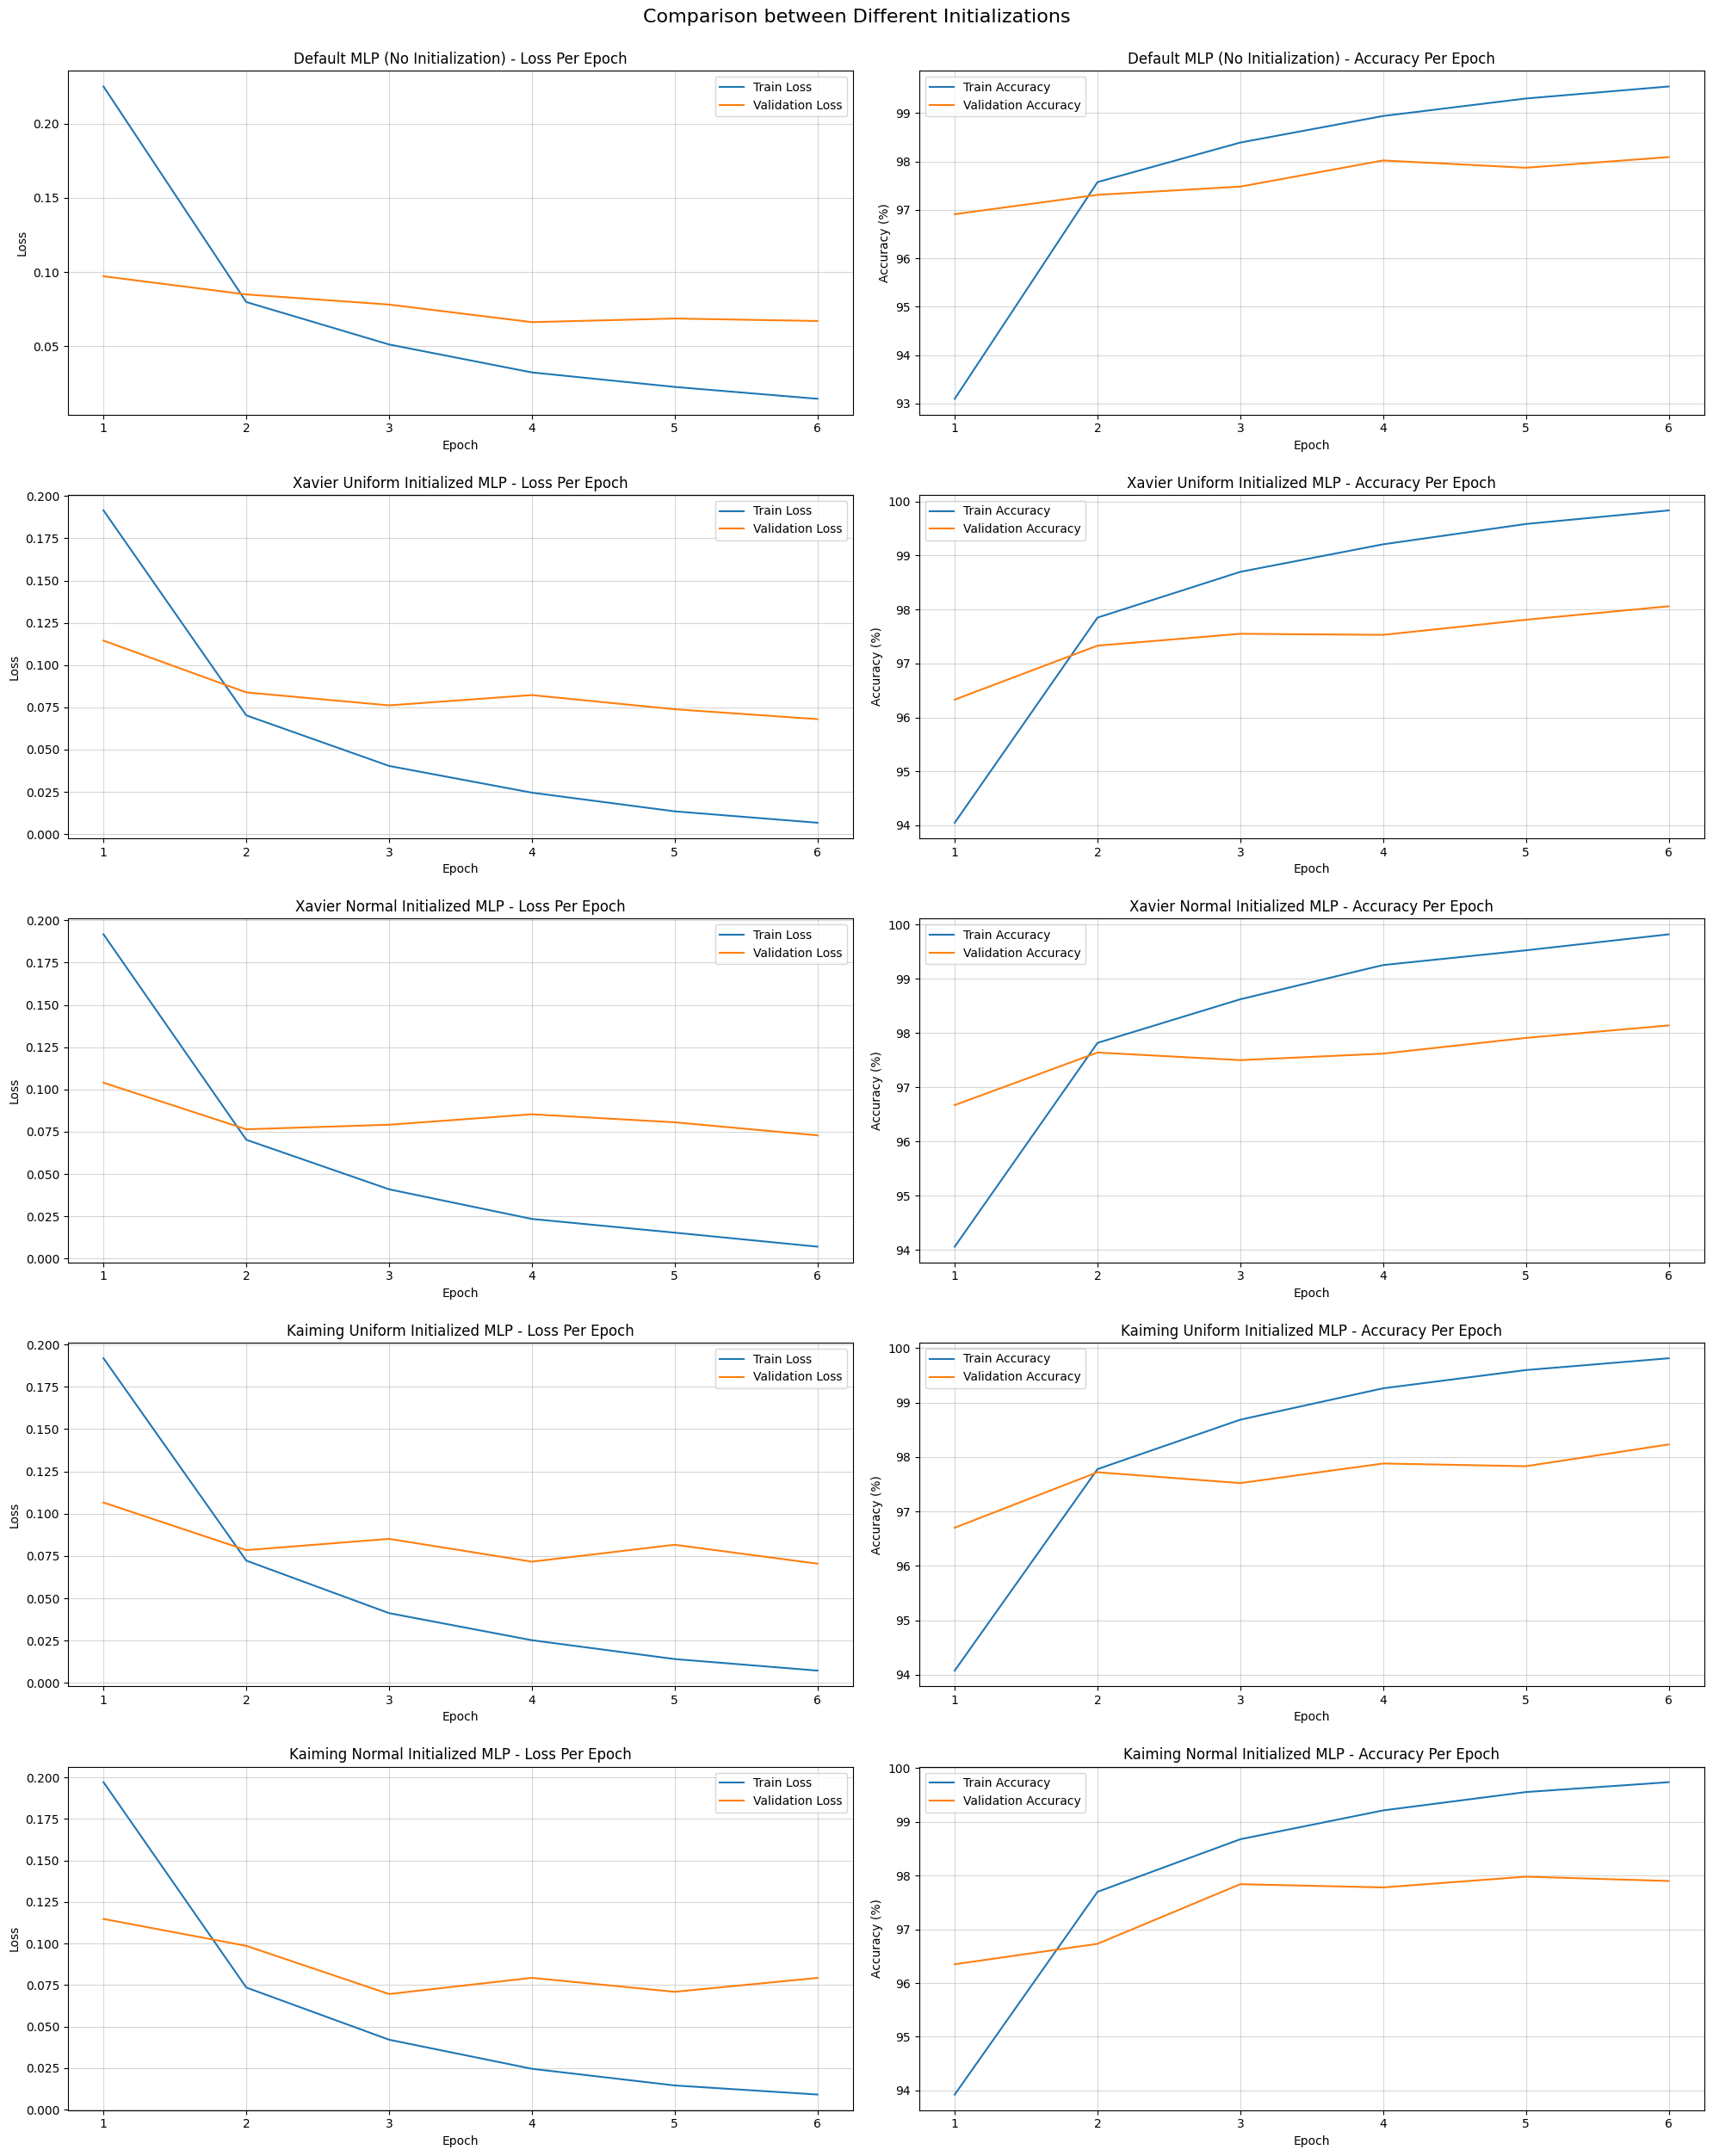

In [12]:
# Create figure with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(20, 25))

# Data to plot (model metrics)
models_data = [
    (default_model_metrics, "Default MLP (No Initialization)"),
    (xavier_uniform_model_metrics, "Xavier Uniform Initialized MLP"),
    (xavier_normal_model_metrics, "Xavier Normal Initialized MLP"),
    (kaiming_uniform_model_metrics, "Kaiming Uniform Initialized MLP"),
    (kaiming_normal_model_metrics, "Kaiming Normal Initialized MLP")
]

# Create plots for each model
for i, (metrics, title) in enumerate(models_data):
    # Left plot (loss)
    ax_left = axes[i, 0]
    ax_left.set_title(f"{title} - Loss Per Epoch")
    ax_left.grid(True, alpha=0.5)
    ax_left.set_xlabel("Epoch")
    ax_left.set_ylabel("Loss")
    p1 = ax_left.plot(metrics["epochs"], metrics["train_loss_history"], label='Train Loss')
    p2 = ax_left.plot(metrics["epochs"], metrics["val_loss_history"], label='Validation Loss')
    ax_left.legend()

    # Right plot (accuracy)
    ax_right = axes[i, 1]
    ax_right.set_title(f"{title} - Accuracy Per Epoch")
    ax_right.grid(True, alpha=0.5)
    ax_right.set_xlabel("Epoch")
    ax_right.set_ylabel("Accuracy (%)")
    p3 = ax_right.plot(metrics["epochs"], metrics["train_acc_history"], label='Train Accuracy')
    p4 = ax_right.plot(metrics["epochs"], metrics["val_acc_history"], label='Validation Accuracy')
    ax_right.legend()

# Add overall title and adjust layout
fig.suptitle(f"Comparison between Different Initializations",
             fontsize=16, y=1.0)
fig.tight_layout(h_pad=2.0, w_pad=1.5)

plt.show()